In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_curve, auc, confusion_matrix, 
                           classification_report, RocCurveDisplay)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from datetime import datetime
import os

In [ ]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [13]:
# Fill missing values with the mean of each column
X.fillna(X.mean(), inplace=True)
# Check if there are still any missing values
X.isnull().sum()

C:\Users\hp\AppData\Local\Temp\ipykernel_28620\3191321209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

In [25]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert the scaled features back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [26]:
X_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,0.686202,-2.251775,0.757525,-0.264900,2.394438,1.016684,0.017197,-0.696631,1.087338,2.274579,-0.723095,0.655818
1,1.392002,0.686202,0.877985,1.611220,0.760415,-0.417635,1.016684,-1.821905,1.435481,0.397182,0.649113,2.503851,-0.898522
2,1.392002,0.686202,0.877985,-0.665300,-0.342283,-0.417635,1.016684,-0.902354,1.435481,1.346147,0.649113,1.428203,1.173931
3,-1.932564,0.686202,-0.165268,-0.096170,0.063974,-0.417635,-0.996749,1.637359,-0.696631,2.122573,2.274579,-0.723095,-0.898522
4,-1.489288,-1.457296,-1.208521,-0.096170,-0.825922,-0.417635,1.016684,0.980537,-0.696631,0.310912,-0.976352,-0.723095,-0.898522


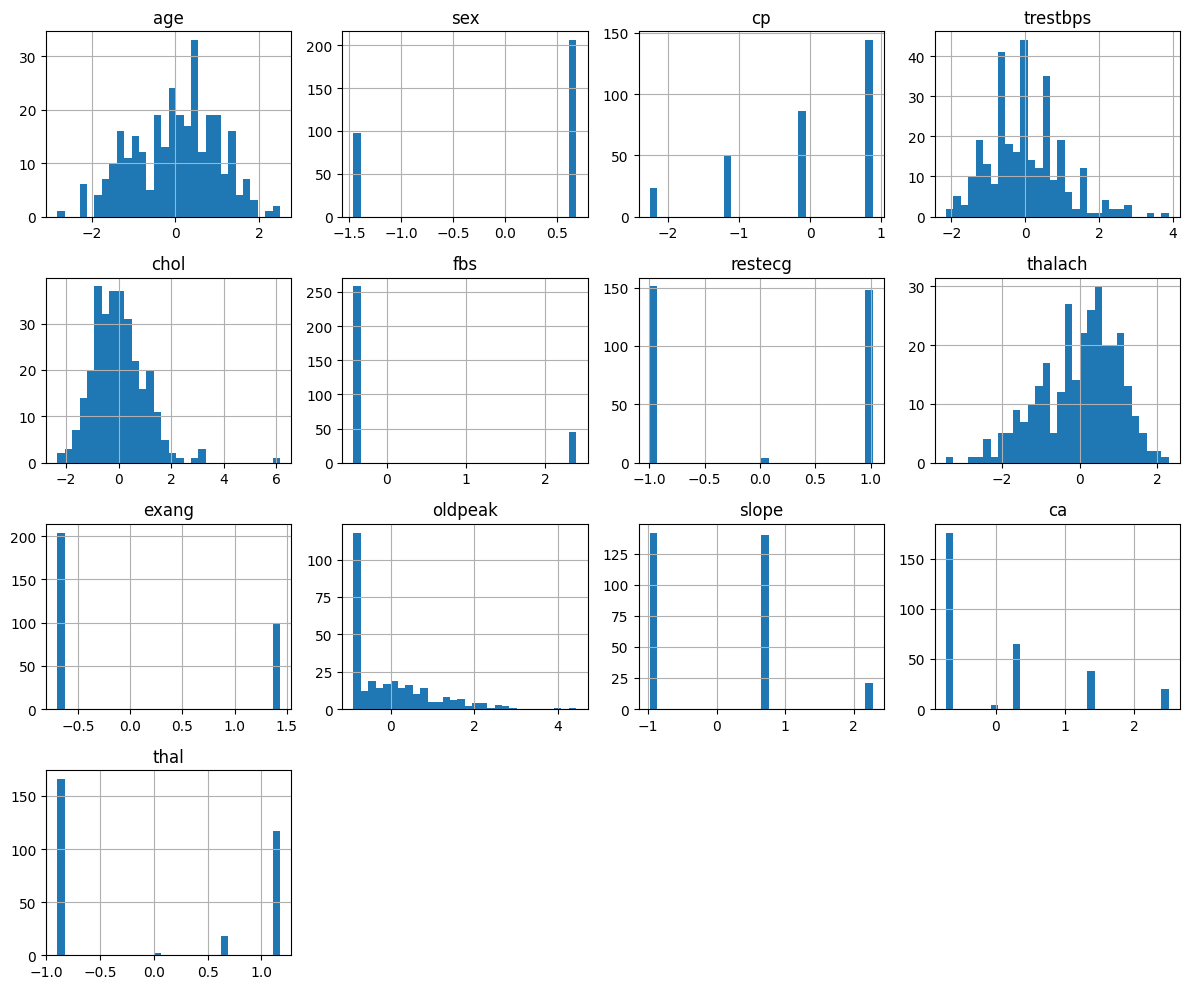

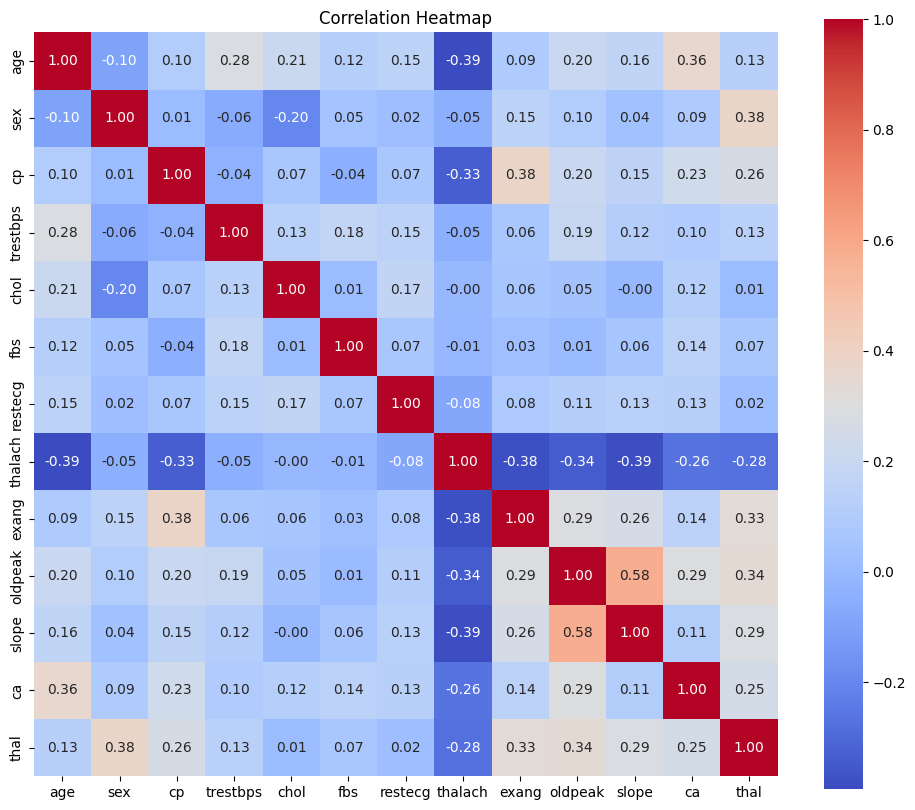

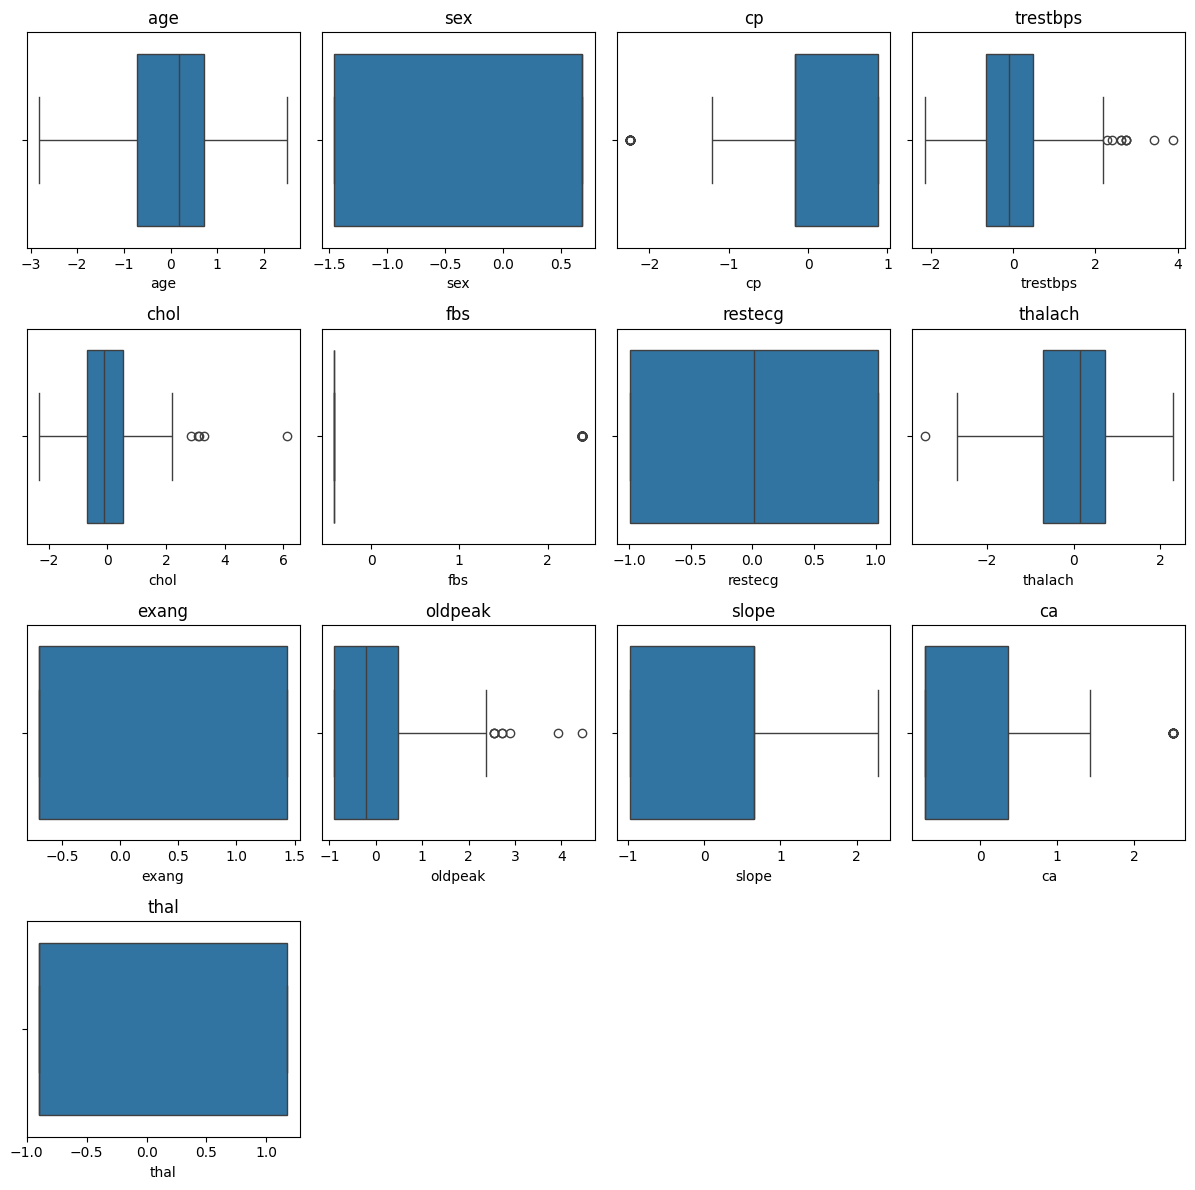

In [ ]:
# Histogram of each feature
X_scaled.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_scaled.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Boxplot for each feature
n_features = len(X_scaled.columns)
n_cols = 4  
n_rows = (n_features // n_cols) + 1 

plt.figure(figsize=(12, 3 * n_rows))  
for i, column in enumerate(X_scaled.columns, 1):  
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=X_scaled[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
def perform_pca_analysis(X_scaled, y=None, target_name='Target'):
    # 1. Perform PCA with all components first
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # 2. Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 3. Find optimal number of components (95% variance)
    optimal_n = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"We need {optimal_n} components to keep 95% of the variance")

    # 4. Create the visualizations
    plt.figure(figsize=(15, 5))

    # Plot 1: Variance analysis
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, label='Individual')
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-', label='Cumulative')
    plt.axhline(0.95, color='red', linestyle='--', label='95% threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by PCA Components')
    plt.legend()
    plt.grid(True)

    # Plot 2: PCA scatter plot
    plt.subplot(1, 2, 2)
    if y is not None:
        # Convert y to numpy array if it's pandas
        y_values = y.values if hasattr(y, 'values') else y
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_values, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label=target_name)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
    
    plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)')
    plt.title('First Two Principal Components')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 5. Return optimal PCA transformation
    pca_optimal = PCA(n_components=optimal_n)
    X_pca_optimal = pca_optimal.fit_transform(X_scaled)
    
    return X_pca_optimal, pca_optimal

We need 12 components to keep 95% of the variance


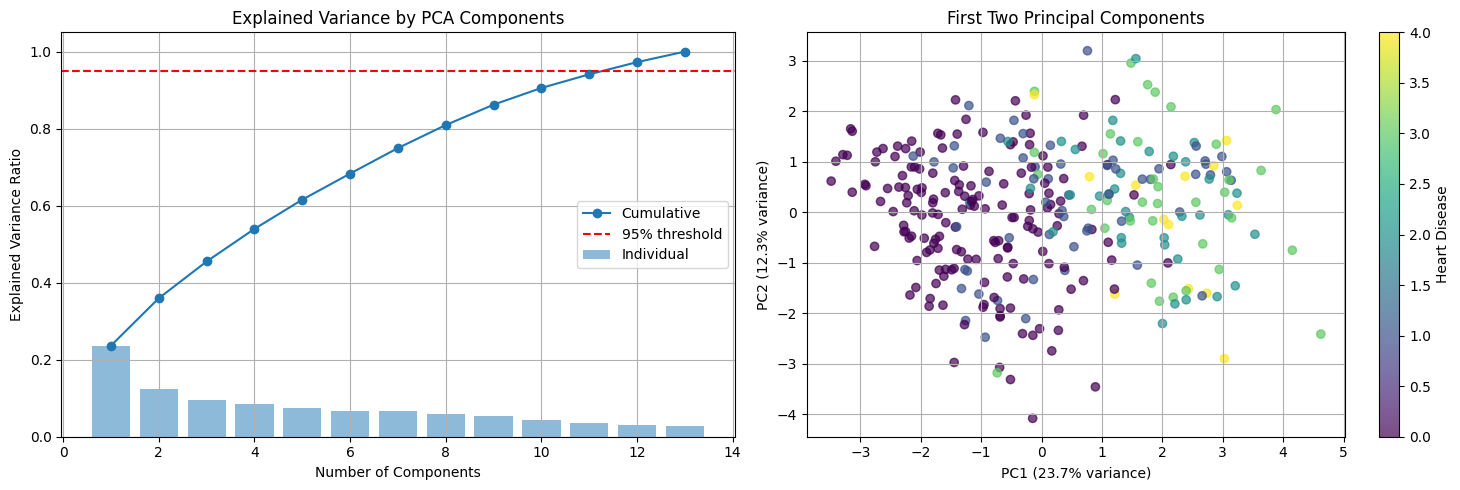

In [49]:
X_pca, pca = perform_pca_analysis(X_scaled, y, 'Heart Disease')

=== Feature Importance ===


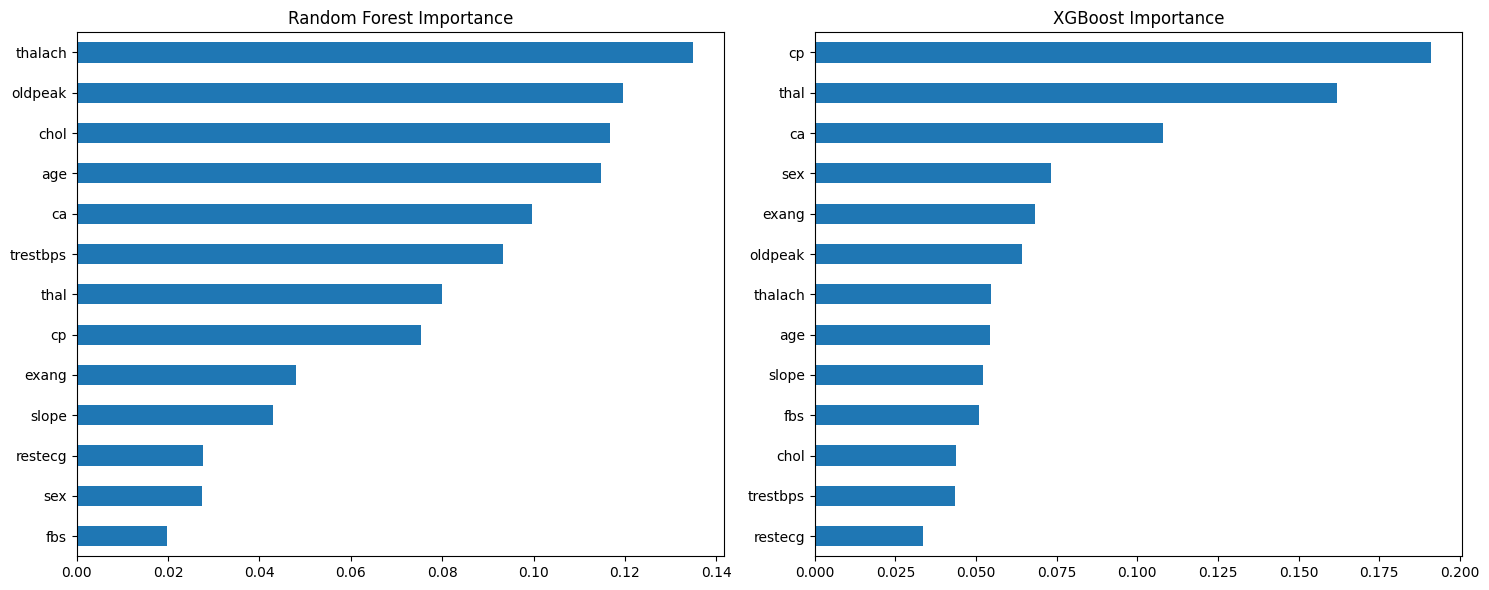


=== Recursive Feature Elimination ===
RFE Selected Features: ['age', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

=== Chi-Square Test ===
Significant Features (p < 0.05): ['exang', 'oldpeak', 'slope', 'ca', 'thal']

=== Combined Feature Selection ===
Final Selected Features: ['sex', 'thalach', 'cp', 'fbs', 'restecg', 'age', 'chol', 'trestbps', 'oldpeak', 'ca']


In [ ]:
def feature_selection_analysis(X, y, n_features_to_select=10):
    """Comprehensive feature selection with proper handling for Chi-Square test"""
    results = {}
    
    # 1. Feature Importance
    print("=== Feature Importance ===")
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
    
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X, y)
    xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    rf_importance.sort_values().plot(kind='barh', ax=ax1, title='Random Forest Importance')
    xgb_importance.sort_values().plot(kind='barh', ax=ax2, title='XGBoost Importance')
    plt.tight_layout()
    plt.show()
    
    # 2. Recursive Feature Elimination
    print("\n=== Recursive Feature Elimination ===")
    rfe = RFE(RandomForestClassifier(random_state=42), n_features_to_select=n_features_to_select)
    rfe.fit(X, y)
    rfe_selected = pd.Series(rfe.support_, index=X.columns, name='RFE_Selected')
    print("RFE Selected Features:", rfe_selected[rfe_selected].index.tolist())
    
    # 3. Chi-Square Test 
    print("\n=== Chi-Square Test ===")
    # Create non-negative version for chi2 test
    X_non_neg = X - X.min() + 1e-6  
    
    chi_scores, p_values = chi2(X_non_neg, y)
    chi_results = pd.DataFrame({'Chi-Score': chi_scores, 'P-Value': p_values}, index=X.columns)
    print("Significant Features (p < 0.05):", chi_results[chi_results['P-Value'] < 0.05].index.tolist())
    
    # 4. Combined Selection
    print("\n=== Combined Feature Selection ===")
    feature_scores = pd.DataFrame({
        'RF_Rank': rf_importance.rank(ascending=False),
        'XGB_Rank': xgb_importance.rank(ascending=False),
        'RFE_Selected': rfe_selected.astype(int),
        'Chi_Sig': (p_values < 0.05).astype(int)
    })
    
    feature_scores['Total_Score'] = (
        feature_scores['RF_Rank'] + 
        feature_scores['XGB_Rank'] + 
        feature_scores['RFE_Selected'] * len(X.columns) + 
        feature_scores['Chi_Sig'] * len(X.columns)
    )
    
    top_features = feature_scores.nsmallest(n_features_to_select, 'Total_Score').index.tolist()
    print("Final Selected Features:", top_features)
    
    return top_features

# Now run feature selection
selected_features = feature_selection_analysis(X_scaled, y, n_features_to_select=10)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        33
           1       0.44      0.36      0.40        11
           2       0.20      0.14      0.17         7
           3       0.43      0.43      0.43         7
           4       0.00      0.00      0.00         3

    accuracy                           0.64        61
   macro avg       0.37      0.37      0.37        61
weighted avg       0.58      0.64      0.61        61

Confusion Matrix:
[[31  1  1  0  0]
 [ 6  4  1  0  0]
 [ 2  1  1  3  0]
 [ 0  1  2  3  1]
 [ 0  2  0  1  0]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        33
           1       0.10      0.09      0.10        11
           2       0.11      0.14      0.12         7
           3       0.00      0.00      0.00         7
           4       0.50      0.33      0.40      

d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniFo


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.10      0.09      0.10        11
           2       0.00      0.00      0.00         7
           3       0.14      0.14      0.14         7
           4       0.00      0.00      0.00         3

    accuracy                           0.54        61
   macro avg       0.20      0.23      0.22        61
weighted avg       0.45      0.54      0.49        61

Confusion Matrix:
[[31  1  1  0  0]
 [ 7  1  1  2  0]
 [ 1  4  0  2  0]
 [ 1  3  2  1  0]
 [ 0  1  0  2  0]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        33
           1       0.12      0.09      0.11        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accura

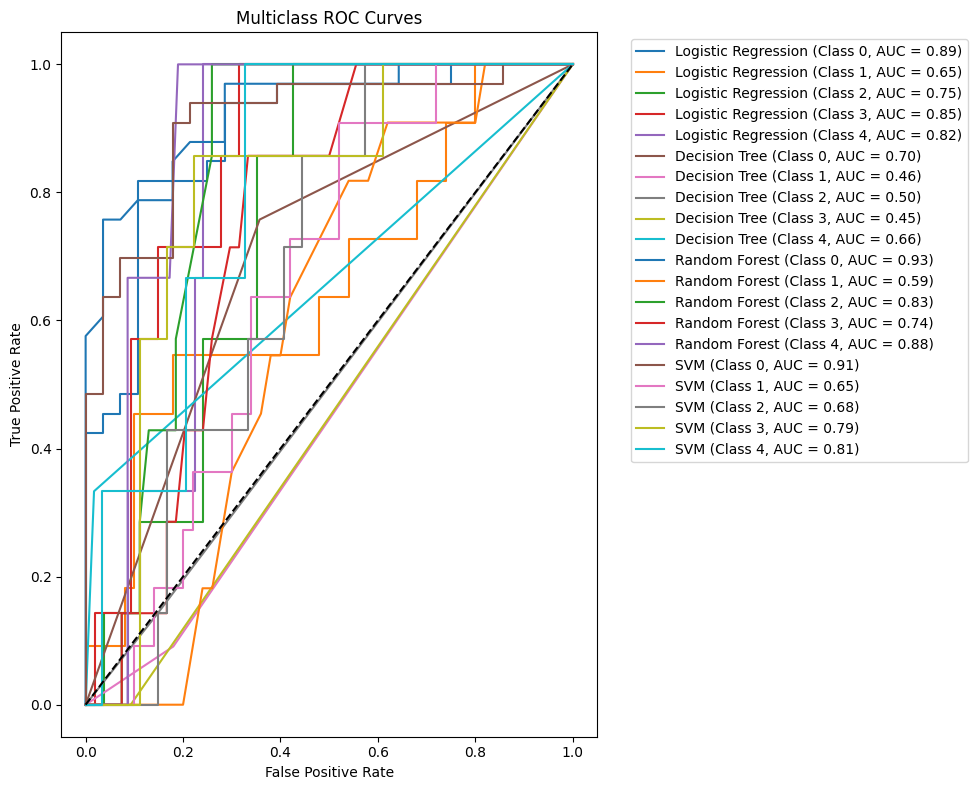


Model Performance Summary:


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.639344,0.582289,0.639344,0.606284,0.792805
Decision Tree,0.459016,0.441790,0.459016,0.448973,0.552955
Random Forest,0.540984,0.453689,0.540984,0.493033,0.794826
SVM,0.540984,0.425133,0.540984,0.474547,0.768925


In [ ]:
# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Scale features
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# 3. Initialize models
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), 
                                       OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": make_pipeline(StandardScaler(), 
                        OneVsRestClassifier(SVC(probability=True, random_state=42)))
}

# 4. Train and evaluate models
results = {}
plt.figure(figsize=(10, 8))

# Binarize y for multiclass ROC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in models.items():
    # Train
    if "SVM" in name or "Logistic" in name:
        model.fit(X_train_standard, y_train)
    else:
        model.fit(X_train_minmax, y_train)
    
    # Predict
    y_pred = model.predict(X_test_standard if ("SVM" in name or "Logistic" in name) else X_test_minmax)
    y_proba = model.predict_proba(X_test_standard if ("SVM" in name or "Logistic" in name) else X_test_minmax)
    
    # Calculate metrics with weighted average
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC Curve (one-vs-rest for multiclass)
    fpr, tpr, roc_auc = {}, {}, {}
    for i, class_label in enumerate(classes):
        fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])
    
    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": np.mean(list(roc_auc.values())),  # Mean AUC across classes
    }
    
    # Plot ROC for each class
    for class_label in classes:
        plt.plot(fpr[class_label], tpr[class_label], 
                 label=f'{name} (Class {class_label}, AUC = {roc_auc[class_label]:.2f})')
    
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# 5. Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Display results summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
display(results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']))

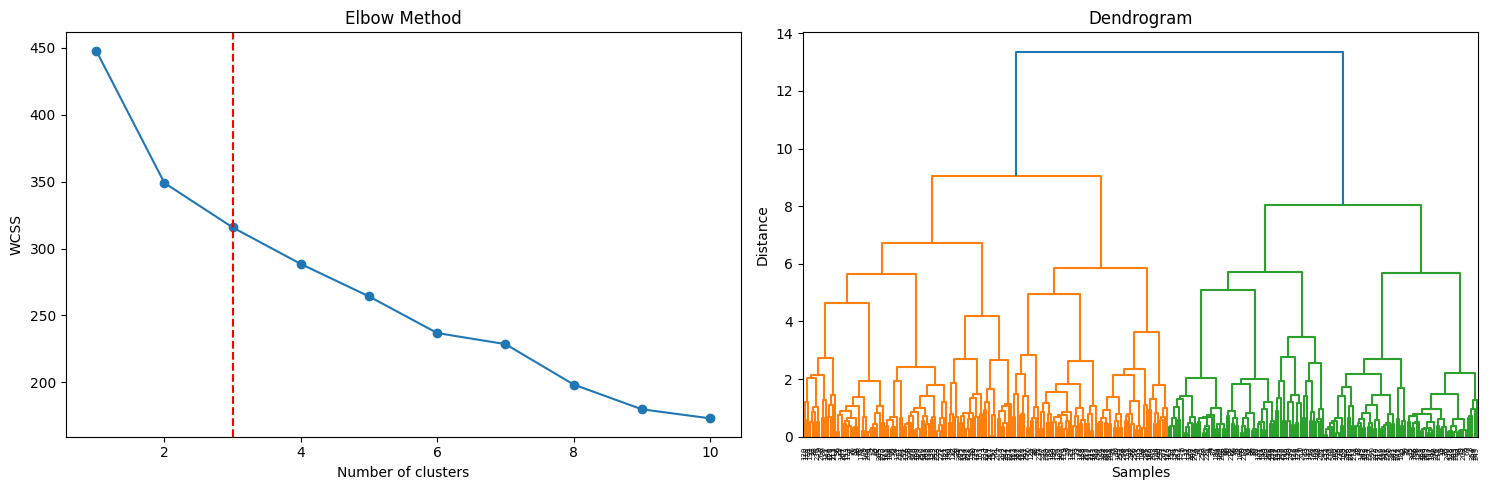


Cluster vs Actual Label Comparison:
K-Means ARI: 0.274
Hierarchical ARI: 0.230

K-Means vs Actual Labels:
col_0   0    1   2  All
num                    
0      11  121  32  164
1      14   19  22   55
2      12    4  20   36
3      19    2  14   35
4       7    0   6   13
All    63  146  94  303

Hierarchical vs Actual Labels:
col_0    0   1   2  All
num                    
0      115  23  26  164
1       16  23  16   55
2        4  20  12   36
3        3  22  10   35
4        1   6   6   13
All    139  94  70  303

Clustering Quality Metrics:
K-Means Silhouette Score: 0.190
Hierarchical Silhouette Score: 0.185


In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.axvline(x=3, color='r', linestyle='--')  

# 1. Hierarchical Clustering with Dendrogram
plt.subplot(1, 2, 2)
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--')  
plt.tight_layout()
plt.show()

# 2. Perform clustering with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# 3. Compare with actual labels
if hasattr(heart_disease, 'targets'):
    y_true = heart_disease.data.targets.iloc[:, 0]
    print("\nCluster vs Actual Label Comparison:")
    print(f"K-Means ARI: {adjusted_rand_score(y_true, kmeans_labels):.3f}")
    print(f"Hierarchical ARI: {adjusted_rand_score(y_true, hierarchical_labels):.3f}")
    
    # Cross-tabulation
    print("\nK-Means vs Actual Labels:")
    print(pd.crosstab(y_true, kmeans_labels, margins=True))
    
    print("\nHierarchical vs Actual Labels:")
    print(pd.crosstab(y_true, hierarchical_labels, margins=True))
else:
    print("\nNo ground truth labels available for comparison")

# 4. Evaluate clustering quality
print("\nClustering Quality Metrics:")
print(f"K-Means Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"Hierarchical Silhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.3f}")

In [ ]:
# 1. Prepare data
X_train_final = X_train[selected_features] 
X_test_final = X_test[selected_features]

# 2. Baseline Models
print("=== BASELINE MODELS ===")
baseline_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

for name, model in baseline_models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    print(f"\n{name} Baseline Performance:")
    print(classification_report(y_test, y_pred))

# 3. Hyperparameter Optimization
print("\n=== HYPERPARAMETER OPTIMIZATION ===")

# Random Forest parameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# SVM parameter grid
svm_params = {
    'C': np.logspace(-3, 2, 6),
    'gamma': np.logspace(-3, 2, 6),
    'kernel': ['linear', 'rbf', 'poly']
}

# GridSearch for Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_final, y_train)

# RandomizedSearch for SVM 
svm_random = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=svm_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
svm_random.fit(X_train_final, y_train)

# 4. Compare Optimized Models
optimized_models = {
    "Optimized Random Forest": rf_grid.best_estimator_,
    "Optimized SVM": svm_random.best_estimator_
}

print("\n=== OPTIMIZED MODELS ===")
for name, model in optimized_models.items():
    y_pred = model.predict(X_test_final)
    print(f"\n{name} Performance:")
    print(f"Best Parameters: {model.get_params()}")
    print(classification_report(y_test, y_pred))

# 5. Performance Comparison Summary
print("\n=== PERFORMANCE COMPARISON ===")
comparison = []
for name, model in {**baseline_models, **optimized_models}.items():
    y_pred = model.predict(X_test_final)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    comparison.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

comparison_df = pd.DataFrame(comparison).set_index('Model')
print(comparison_df.sort_values('F1-score', ascending=False))

=== BASELINE MODELS ===

Random Forest Baseline Performance:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        33
           1       0.00      0.00      0.00        11
           2       0.20      0.14      0.17         7
           3       0.14      0.14      0.14         7
           4       0.00      0.00      0.00         3

    accuracy                           0.52        61
   macro avg       0.22      0.24      0.23        61
weighted avg       0.45      0.52      0.48        61


SVM Baseline Performance:
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        33
           1       0.31      0.36      0.33        11
           2       0.00      0.00      0.00         7
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg       0.27      0.28      0.26

d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== OPTIMIZED MODELS ===

Optimized Random Forest Performance:
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        33
           1       0.18      0.18      0.18        11
           2       0.33      0.14      0.20         7
           3       0.33      0.29      0.31         7
           4       0.00      0.00      0.00         3

    accuracy                           0.59        61

d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniForge3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Installation\MiniFo

                         Precision    Recall  F1-score
Model                                                 
Optimized Random Forest   0.518326  0.590164  0.544303
SVM                       0.471167  0.573770  0.510152
Random Forest             0.445082  0.524590  0.480163
Optimized SVM             0.382328  0.540984  0.445102


In [98]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import plotly.express as px

# Load the trained pipeline
@st.cache_resource
def load_model():
    return joblib.load("D:\Development\Programming\AI\Sprints Final Project\heart_disease_models\RandomForest_pipeline.pkl")

model = load_model()

# Page config
st.set_page_config(page_title="Heart Disease Predictor", layout="wide")

st.title("💓 Heart Disease Risk Predictor")
st.markdown("This app uses a trained machine learning model to assess your risk of heart disease.")

# Sidebar inputs
st.sidebar.header("🔎 Enter Patient Data")

# Input form
def get_user_input():
    age = st.sidebar.slider("Age", 20, 100, 55)
    sex = st.sidebar.radio("Sex", ["Male", "Female"])
    cp = st.sidebar.selectbox("Chest Pain Type (0-3)", [0, 1, 2, 3])
    trestbps = st.sidebar.slider("Resting Blood Pressure (mm Hg)", 90, 200, 130)
    chol = st.sidebar.slider("Cholesterol (mg/dL)", 100, 600, 250)
    fbs = st.sidebar.checkbox("Fasting Blood Sugar > 120 mg/dL")
    restecg = st.sidebar.selectbox("Resting ECG Results", [0, 1, 2])
    thalach = st.sidebar.slider("Max Heart Rate Achieved", 60, 220, 160)
    exang = st.sidebar.checkbox("Exercise Induced Angina")
    oldpeak = st.sidebar.slider("ST Depression", 0.0, 6.2, 1.0, step=0.1)
    ca = st.sidebar.slider("Number of Major Vessels (0–3)", 0, 3, 0)
    thal = st.sidebar.selectbox("Thalassemia", [1, 2, 3])  # Assuming numerical encoding

    # Format input as DataFrame
    input_data = pd.DataFrame([{
        'age': age,
        'sex': 1 if sex == "Male" else 0,
        'cp': cp,
        'trestbps': trestbps,
        'chol': chol,
        'fbs': 1 if fbs else 0,
        'restecg': restecg,
        'thalach': thalach,
        'exang': 1 if exang else 0,
        'oldpeak': oldpeak,
        'ca': ca,
        'thal': thal
    }])

    return input_data

input_df = get_user_input()

# Predict and display results
if st.button("💡 Predict Risk"):
    try:
        prediction = model.predict(input_df)[0]
        probability = model.predict_proba(input_df)[0][1]

        st.subheader("🩺 Prediction Result")
        st.markdown(f"### {'⚠️ High Risk' if prediction == 1 else '✅ Low Risk'}")
        st.markdown(f"**Probability of Heart Disease:** `{probability * 100:.2f}%`")

        # Pie Chart
        fig = px.pie(
            names=["No Disease", "Disease"],
            values=[1 - probability, probability],
            color_discrete_sequence=["#2ECC71", "#E74C3C"]
        )
        st.plotly_chart(fig, use_container_width=True)

        # Health Advice
        with st.expander("💬 Health Recommendations"):
            if prediction == 1:
                st.warning("Consult a cardiologist. Consider improving diet, exercise, and stress levels.")
            else:
                st.success("Keep up your good health with regular checkups and a healthy lifestyle.")

    except Exception as e:
        st.error(f"Prediction failed: {e}")


Overwriting app.py
